In [ ]:
!pip install -q condacolab

In [ ]:
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:15
🔁 Restarting kernel...


In [ ]:
!conda install wradlib
!conda install -c conda-forge pyproj

Channels:
 - conda-forge
Platform: linux-64
Solving environment: | / - \ | / - \ | / - done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.9.2

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - wradlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    aws-c-auth-0.7.11          |       h0b4cabd_1         101 KB  conda-forge
    aws-c-cal-0.6.9            |       h14ec70c_3          54 KB  conda-forge
    aws-c-common-0.9.12        |       hd590300_0         220 KB  conda-forge
    aws-c-compression-0.2.17   |       h572eabf_8          19 KB  conda-forge
    aws-c-event-stream-0.4.1   |       h97bb272_2          53 KB  conda-forge
    aws-c-http-0.8.0           |       h9129f04_2         190 K

In [ ]:
import os
import wradlib as wrl
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

warnings.filterwarnings("ignore")
try:
    get_ipython().run_line_magic("matplotlib", "inline")
except:
    plt.ion()
import numpy as np
from osgeo import osr
import pyproj

/usr/local/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [ ]:
!find / -name "proj.db" 2>/dev/null

/usr/share/proj/proj.db
/usr/local/share/proj/proj.db
/usr/local/lib/python3.10/dist-packages/pyproj/proj_dir/share/proj/proj.db
/usr/local/lib/python3.10/dist-packages/pyogrio/proj_data/proj.db
/usr/local/pkgs/proj-9.3.1-h1d62c97_0/share/proj/proj.db
/usr/local/pkgs/proj-9.4.0-hb784bbd_2/share/proj/proj.db


In [ ]:
# Replace with the actual path if it's different
proj_lib = "/usr/local/share/proj"
os.environ["PROJ_LIB"] = proj_lib

In [ ]:
sitecoords = (-49.461029, -27.230154, 895.0) #Lontras
nrays = 348  # number of rays
nbins = 1920  # number of range bins
el = 0.5  # vertical antenna pointing angle (deg) SIMULATED
bw = 0.5  # half power beam width (deg) obs. atentar que é metade
range_res = 125.0  # range resolution (meters)

In [ ]:
#Create the range, azimuth, and beamradius arrays.
r = np.arange(nbins) * range_res
beamradius = wrl.util.half_power_radius(r, bw)

#to calculate the spherical coordinates of the bin centroids and their longitude, latitude and altitude.
coord = wrl.georef.sweep_centroids(nrays, range_res, nbins, el)
coords = wrl.georef.spherical_to_proj(
    coord[..., 0], coord[..., 1], coord[..., 2], sitecoords
)
lon = coords[..., 0]
lat = coords[..., 1]
alt = coords[..., 2]

polcoords = coords[..., :2]
#print("lon,lat,alt:", coords.shape)

#Limites do radar
rlimits = (lon.min(), lat.min(), lon.max(), lat.max())
print(
    "Radar bounding box:\n\t%.2f\n%.2f             %.2f\n\t%.2f"
    % (lat.max(), lon.min(), lon.max(), lat.min())
)

Radar bounding box:
	-25.07
-51.88             -47.04
	-29.39


In [ ]:
#Preprocessing the digitial elevation model (DEM)
#https://earthexplorer.usgs.gov/ data for GTOPO30. There is necessety to login
polcoords = coords[..., :2]

rasterfile = "/content/gt30w060s10.tif"

ds = wrl.io.open_raster(rasterfile)
rastervalues, rastercoords, crs = wrl.georef.extract_raster_dataset(ds, nodata=-32768.0)

# Clip the region inside our bounding box
ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
rastercoords = rastercoords[ind[1] : ind[3], ind[0] : ind[2], ...]
rastervalues = rastervalues[ind[1] : ind[3], ind[0] : ind[2]]

# Map rastervalues to polar grid points
polarvalues = wrl.ipol.cart_to_irregular_spline(
    rastercoords, rastervalues, polcoords, order=3, prefilter=False
)

In [ ]:
#Calculate Beamblockage
PBB = wrl.qual.beam_block_frac(polarvalues, alt, beamradius)
PBB = np.ma.masked_invalid(PBB)
print(PBB.shape)

(348, 1920)


In [ ]:
#Cumulative beam blockage (CBB)
CBB = wrl.qual.cum_beam_block_frac(PBB)
print(CBB.shape)

(348, 1920)


In [ ]:
#Visualize Beamblockage
# just a little helper function to style x and y axes of our maps
def annotate_map(ax, cm=None, title=""):
    ticks = (ax.get_xticks() / 1000).astype(int)
    ax.set_xticklabels(ticks)
    ticks = (ax.get_yticks() / 1000).astype(int)
    ax.set_yticklabels(ticks)
    ax.set_xlabel("Kilometers")
    ax.set_ylabel("Kilometers")
    #if not cm is None:
    #    plt.colorbar(cm, ax=ax)
    if not title == "":
        ax.set_title(title)
    ax.grid()

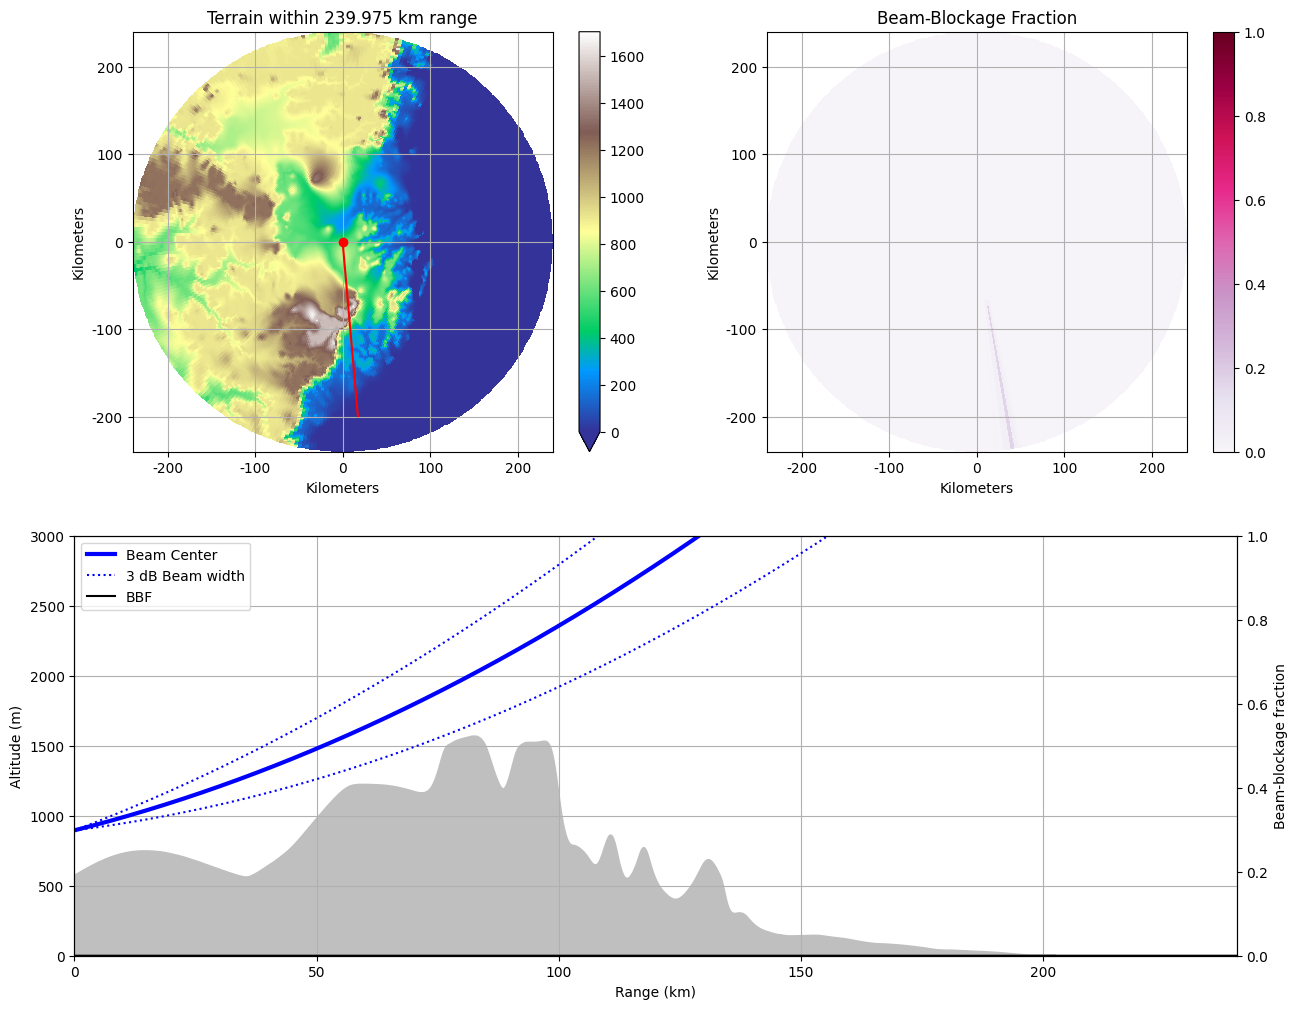

In [ ]:
fig = plt.figure(figsize=(15, 12))

# create subplots
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2, rowspan=1)

# azimuth angle
angle = 175


# Plot terrain (on ax1)
polarvalues = wrl.georef.create_xarray_dataarray(
    polarvalues, r=r, phi=coord[:, 0, 1]
).wrl.georef.georeference()
dem = polarvalues.wrl.vis.plot(ax=ax1, cmap=mpl.cm.terrain, vmin=0.0)
ax1.plot(
    [0, np.sin(np.radians(angle)) * 2e5], [0, np.cos(np.radians(angle)) * 2e5], "r-"
)
ax1.plot(sitecoords[0], sitecoords[1], "ro")
annotate_map(ax1, dem, "Terrain within {0} km range".format(np.max(r / 1000.0) + 0.1))

# Plot CBB (on ax2)
CBB = wrl.georef.create_xarray_dataarray(
    CBB, r=r, phi=coord[:, 0, 1]
).wrl.georef.georeference()
cbb = CBB.wrl.vis.plot(ax=ax2, cmap=mpl.cm.PuRd, vmin=0, vmax=1)
annotate_map(ax2, cbb, "Beam-Blockage Fraction")

# Plot single ray terrain profile on ax3
(bc,) = ax3.plot(r / 1000.0, alt[angle, :], "-b", linewidth=3, label="Beam Center")
(b3db,) = ax3.plot(
    r / 1000.0,
    (alt[angle, :] + beamradius),
    ":b",
    linewidth=1.5,
    label="3 dB Beam width",
)
ax3.plot(r / 1000.0, (alt[angle, :] - beamradius), ":b")
ax3.fill_between(r / 1000.0, 0.0, polarvalues[angle, :], color="0.75")
ax3.set_xlim(0.0, np.max(r / 1000.0) + 0.1)
ax3.set_ylim(0.0, 3000)
ax3.set_xlabel("Range (km)")
ax3.set_ylabel("Altitude (m)")
ax3.grid()

axb = ax3.twinx()
(bbf,) = axb.plot(r / 1000.0, CBB[angle, :], "-k", label="BBF")
axb.set_ylabel("Beam-blockage fraction")
axb.set_ylim(0.0, 1.0)
axb.set_xlim(0.0, np.max(r / 1000.0) + 0.1)


legend = ax3.legend(
    (bc, b3db, bbf),
    ("Beam Center", "3 dB Beam width", "BBF"),
    loc="upper left",
    fontsize=10,
)